In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.utils import to_categorical

import cv2

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
cv2_image = cv2.imread("./FER-2013-5emotion/train/angry/Training_992349.jpg")
print(cv2_image)

[[[ 23  23  23]
  [ 52  52  52]
  [ 54  54  54]
  ...
  [173 173 173]
  [ 98  98  98]
  [ 42  42  42]]

 [[ 23  23  23]
  [ 48  48  48]
  [ 53  53  53]
  ...
  [174 174 174]
  [104 104 104]
  [ 34  34  34]]

 [[ 30  30  30]
  [ 50  50  50]
  [ 55  55  55]
  ...
  [175 175 175]
  [113 113 113]
  [ 36  36  36]]

 ...

 [[ 31  31  31]
  [ 28  28  28]
  [ 29  29  29]
  ...
  [ 54  54  54]
  [ 80  80  80]
  [101 101 101]]

 [[ 31  31  31]
  [ 29  29  29]
  [ 30  30  30]
  ...
  [ 55  55  55]
  [ 80  80  80]
  [ 96  96  96]]

 [[ 29  29  29]
  [ 31  31  31]
  [ 28  28  28]
  ...
  [ 59  59  59]
  [ 79  79  79]
  [ 89  89  89]]]


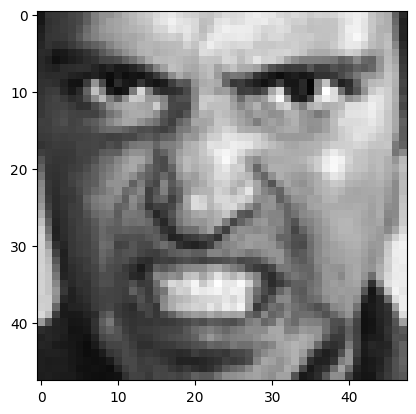

In [5]:
plt.imshow(cv2_image)

In [6]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [7]:
BATCH_SIZE = 32

In [8]:
train_generator = train_data_gen.flow_from_directory(
    './FER-2013-5emotion/train',
    subset='training',
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 19341 images belonging to 5 classes.


In [9]:
valid_generator = train_data_gen.flow_from_directory(
    './FER-2013-5emotion/train',
    subset='validation',
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 4835 images belonging to 5 classes.


In [10]:
test_generator = test_data_gen.flow_from_directory(
    './FER-2013-5emotion/test',
    target_size = (48, 48),
    batch_size = BATCH_SIZE,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 6043 images belonging to 5 classes.


In [11]:
model = Sequential()
#model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(48, 48, 1), padding='same'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [12]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(48, 48, 1), padding='same'))
# model.add(Conv2D(64, kernel_size=(3,3)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
# model.add(Conv2D(256, kernel_size=(3,3)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
# model.add(Conv2D(512, kernel_size=(3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# # model.add(Dense(128, activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Dense(5, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 256)       295168    
                                                        

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, decay=0.0001), metrics=['accuracy'])

In [14]:
checkpoint = ModelCheckpoint(filepath='c://Projects/emotion_detect_project/best_model_5emotion/', monitor='val_loss', mode='min', save_vest_only=True)

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_delta=0.0005, mode="min")

In [17]:
emotion_model_info = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = 100,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // BATCH_SIZE,
    callbacks=[checkpoint, earlystopping, reduce_lr]
)

Epoch 1/100
602/604 [============================>.] - ETA: 0s - loss: 1.5757 - accuracy: 0.2966

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 19s 24ms/step - loss: 1.5758 - accuracy: 0.2963 - val_loss: 1.5670 - val_accuracy: 0.2997 - lr: 0.0010
Epoch 2/100
602/604 [============================>.] - ETA: 0s - loss: 1.4624 - accuracy: 0.3623

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 1.4617 - accuracy: 0.3628 - val_loss: 1.3429 - val_accuracy: 0.4373 - lr: 0.0010
Epoch 3/100
604/604 [==============================] - ETA: 0s - loss: 1.2894 - accuracy: 0.4644

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 1.2894 - accuracy: 0.4644 - val_loss: 1.1670 - val_accuracy: 0.5207 - lr: 0.0010
Epoch 4/100
602/604 [============================>.] - ETA: 0s - loss: 1.1460 - accuracy: 0.5296

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 1.1457 - accuracy: 0.5300 - val_loss: 1.0833 - val_accuracy: 0.5563 - lr: 0.0010
Epoch 5/100
602/604 [============================>.] - ETA: 0s - loss: 1.0614 - accuracy: 0.5725

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 1.0615 - accuracy: 0.5725 - val_loss: 0.9931 - val_accuracy: 0.5993 - lr: 0.0010
Epoch 6/100
604/604 [==============================] - ETA: 0s - loss: 0.9990 - accuracy: 0.6046

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.9990 - accuracy: 0.6046 - val_loss: 0.9569 - val_accuracy: 0.6165 - lr: 0.0010
Epoch 7/100
602/604 [============================>.] - ETA: 0s - loss: 0.9452 - accuracy: 0.6257

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.9450 - accuracy: 0.6259 - val_loss: 0.9346 - val_accuracy: 0.6219 - lr: 0.0010
Epoch 8/100
603/604 [============================>.] - ETA: 0s - loss: 0.9050 - accuracy: 0.6496

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.9046 - accuracy: 0.6497 - val_loss: 0.9042 - val_accuracy: 0.6509 - lr: 0.0010
Epoch 9/100
602/604 [============================>.] - ETA: 0s - loss: 0.8702 - accuracy: 0.6595

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.8703 - accuracy: 0.6594 - val_loss: 0.8907 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 10/100
604/604 [==============================] - ETA: 0s - loss: 0.8340 - accuracy: 0.6770

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.8340 - accuracy: 0.6770 - val_loss: 0.8667 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 11/100
604/604 [==============================] - ETA: 0s - loss: 0.7955 - accuracy: 0.6858

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.7955 - accuracy: 0.6858 - val_loss: 0.8744 - val_accuracy: 0.6641 - lr: 0.0010
Epoch 12/100
602/604 [============================>.] - ETA: 0s - loss: 0.7611 - accuracy: 0.7045

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.7609 - accuracy: 0.7046 - val_loss: 0.8686 - val_accuracy: 0.6678 - lr: 0.0010
Epoch 13/100
603/604 [============================>.] - ETA: 0s - loss: 0.7333 - accuracy: 0.7139

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.7336 - accuracy: 0.7138 - val_loss: 0.8639 - val_accuracy: 0.6701 - lr: 0.0010
Epoch 14/100
604/604 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.7318

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.6957 - accuracy: 0.7318 - val_loss: 0.8841 - val_accuracy: 0.6726 - lr: 0.0010
Epoch 15/100
603/604 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.7408

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.6724 - accuracy: 0.7409 - val_loss: 0.8678 - val_accuracy: 0.6722 - lr: 0.0010
Epoch 16/100
604/604 [==============================] - ETA: 0s - loss: 0.6503 - accuracy: 0.7499

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.6503 - accuracy: 0.7499 - val_loss: 0.8618 - val_accuracy: 0.6755 - lr: 0.0010
Epoch 17/100
603/604 [============================>.] - ETA: 0s - loss: 0.6135 - accuracy: 0.7652

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.6135 - accuracy: 0.7652 - val_loss: 0.8644 - val_accuracy: 0.6819 - lr: 0.0010
Epoch 18/100
601/604 [============================>.] - ETA: 0s - loss: 0.5894 - accuracy: 0.7756

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.5898 - accuracy: 0.7752 - val_loss: 0.8636 - val_accuracy: 0.6761 - lr: 0.0010
Epoch 19/100
602/604 [============================>.] - ETA: 0s - loss: 0.5578 - accuracy: 0.7854

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 13s 22ms/step - loss: 0.5583 - accuracy: 0.7852 - val_loss: 0.8994 - val_accuracy: 0.6809 - lr: 0.0010
Epoch 20/100
602/604 [============================>.] - ETA: 0s - loss: 0.5354 - accuracy: 0.7959

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.5352 - accuracy: 0.7959 - val_loss: 0.9316 - val_accuracy: 0.6823 - lr: 0.0010
Epoch 21/100
602/604 [============================>.] - ETA: 0s - loss: 0.5067 - accuracy: 0.8078

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.5071 - accuracy: 0.8078 - val_loss: 0.9172 - val_accuracy: 0.6807 - lr: 0.0010
Epoch 22/100
602/604 [============================>.] - ETA: 0s - loss: 0.4922 - accuracy: 0.8128

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.4918 - accuracy: 0.8130 - val_loss: 0.9029 - val_accuracy: 0.6869 - lr: 0.0010
Epoch 23/100
602/604 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.8208

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.4748 - accuracy: 0.8208 - val_loss: 0.9203 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 24/100
604/604 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8330

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.4462 - accuracy: 0.8330 - val_loss: 0.9423 - val_accuracy: 0.6885 - lr: 0.0010
Epoch 25/100
601/604 [============================>.] - ETA: 0s - loss: 0.4253 - accuracy: 0.8425

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.4248 - accuracy: 0.8428 - val_loss: 0.9648 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 26/100
601/604 [============================>.] - ETA: 0s - loss: 0.4095 - accuracy: 0.8446

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.4088 - accuracy: 0.8449 - val_loss: 0.9774 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 27/100
604/604 [==============================] - ETA: 0s - loss: 0.3501 - accuracy: 0.8704

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.3501 - accuracy: 0.8704 - val_loss: 0.9946 - val_accuracy: 0.6908 - lr: 1.0000e-04
Epoch 28/100
603/604 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8731

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 13s 22ms/step - loss: 0.3361 - accuracy: 0.8732 - val_loss: 0.9945 - val_accuracy: 0.6898 - lr: 1.0000e-04
Epoch 29/100
602/604 [============================>.] - ETA: 0s - loss: 0.3290 - accuracy: 0.8774

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 13s 22ms/step - loss: 0.3290 - accuracy: 0.8774 - val_loss: 0.9987 - val_accuracy: 0.6921 - lr: 1.0000e-04
Epoch 30/100
604/604 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8765

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 13s 22ms/step - loss: 0.3227 - accuracy: 0.8765 - val_loss: 1.0258 - val_accuracy: 0.6918 - lr: 1.0000e-04
Epoch 31/100
602/604 [============================>.] - ETA: 0s - loss: 0.3191 - accuracy: 0.8807

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 13s 22ms/step - loss: 0.3188 - accuracy: 0.8809 - val_loss: 1.0200 - val_accuracy: 0.6929 - lr: 1.0000e-04
Epoch 32/100
604/604 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.8851

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.3100 - accuracy: 0.8851 - val_loss: 1.0214 - val_accuracy: 0.6902 - lr: 1.0000e-04
Epoch 33/100
603/604 [============================>.] - ETA: 0s - loss: 0.3123 - accuracy: 0.8836

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.3119 - accuracy: 0.8838 - val_loss: 1.0272 - val_accuracy: 0.6933 - lr: 1.0000e-04
Epoch 34/100
601/604 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8864

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.2976 - accuracy: 0.8863 - val_loss: 1.0453 - val_accuracy: 0.6921 - lr: 1.0000e-04
Epoch 35/100
604/604 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.8895

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.2979 - accuracy: 0.8895 - val_loss: 1.0521 - val_accuracy: 0.6947 - lr: 1.0000e-04
Epoch 36/100
604/604 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.8898

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.2883 - accuracy: 0.8898 - val_loss: 1.0607 - val_accuracy: 0.6929 - lr: 1.0000e-04
Epoch 37/100
604/604 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8893

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 13s 22ms/step - loss: 0.2966 - accuracy: 0.8893 - val_loss: 1.0558 - val_accuracy: 0.6931 - lr: 1.0000e-05
Epoch 38/100
604/604 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8928

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.2872 - accuracy: 0.8928 - val_loss: 1.0577 - val_accuracy: 0.6945 - lr: 1.0000e-05
Epoch 39/100
604/604 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8914

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.2917 - accuracy: 0.8914 - val_loss: 1.0541 - val_accuracy: 0.6954 - lr: 1.0000e-05
Epoch 40/100
601/604 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8886

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 13s 22ms/step - loss: 0.2976 - accuracy: 0.8886 - val_loss: 1.0493 - val_accuracy: 0.6964 - lr: 1.0000e-05
Epoch 41/100
601/604 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.8854

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.2963 - accuracy: 0.8854 - val_loss: 1.0496 - val_accuracy: 0.6962 - lr: 1.0000e-05
Epoch 42/100
601/604 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8885

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 13s 22ms/step - loss: 0.2962 - accuracy: 0.8883 - val_loss: 1.0487 - val_accuracy: 0.6962 - lr: 1.0000e-05
Epoch 43/100
604/604 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8912

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.2922 - accuracy: 0.8912 - val_loss: 1.0503 - val_accuracy: 0.6974 - lr: 1.0000e-05
Epoch 44/100
603/604 [============================>.] - ETA: 0s - loss: 0.2838 - accuracy: 0.8954

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.2839 - accuracy: 0.8954 - val_loss: 1.0513 - val_accuracy: 0.6968 - lr: 1.0000e-05
Epoch 45/100
604/604 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8936

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 13s 22ms/step - loss: 0.2922 - accuracy: 0.8936 - val_loss: 1.0501 - val_accuracy: 0.6952 - lr: 1.0000e-05
Epoch 46/100
603/604 [============================>.] - ETA: 0s - loss: 0.2920 - accuracy: 0.8886

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.2920 - accuracy: 0.8887 - val_loss: 1.0549 - val_accuracy: 0.6950 - lr: 1.0000e-05
Epoch 47/100
602/604 [============================>.] - ETA: 0s - loss: 0.2867 - accuracy: 0.8942

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.2871 - accuracy: 0.8940 - val_loss: 1.0560 - val_accuracy: 0.6952 - lr: 1.0000e-06
Epoch 48/100
601/604 [============================>.] - ETA: 0s - loss: 0.2877 - accuracy: 0.8913

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.2875 - accuracy: 0.8913 - val_loss: 1.0524 - val_accuracy: 0.6952 - lr: 1.0000e-06
Epoch 49/100
603/604 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.8945

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.2862 - accuracy: 0.8945 - val_loss: 1.0556 - val_accuracy: 0.6954 - lr: 1.0000e-06
Epoch 50/100
601/604 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8955

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.2857 - accuracy: 0.8954 - val_loss: 1.0549 - val_accuracy: 0.6954 - lr: 1.0000e-06
Epoch 51/100
602/604 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.8913

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 22ms/step - loss: 0.2882 - accuracy: 0.8912 - val_loss: 1.0546 - val_accuracy: 0.6954 - lr: 1.0000e-06
Epoch 52/100
602/604 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8921

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.2933 - accuracy: 0.8922 - val_loss: 1.0550 - val_accuracy: 0.6954 - lr: 1.0000e-06
Epoch 53/100
604/604 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.8936

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.2855 - accuracy: 0.8936 - val_loss: 1.0553 - val_accuracy: 0.6952 - lr: 1.0000e-06
Epoch 54/100
603/604 [============================>.] - ETA: 0s - loss: 0.2922 - accuracy: 0.8915

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.2921 - accuracy: 0.8916 - val_loss: 1.0548 - val_accuracy: 0.6956 - lr: 1.0000e-06
Epoch 55/100
601/604 [============================>.] - ETA: 0s - loss: 0.2839 - accuracy: 0.8930

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.2836 - accuracy: 0.8931 - val_loss: 1.0529 - val_accuracy: 0.6958 - lr: 1.0000e-06
Epoch 56/100
604/604 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.8939

INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


INFO:tensorflow:Assets written to: c://Projects/emotion_detect_project/best_model_5emotion\/assets


604/604 [==============================] - 14s 23ms/step - loss: 0.2877 - accuracy: 0.8939 - val_loss: 1.0550 - val_accuracy: 0.6958 - lr: 1.0000e-06


In [18]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size = BATCH_SIZE, steps= test_generator.n//BATCH_SIZE)
print(f"accuracy: {test_accuracy*100:.2f}%")
print(f"loss: {test_loss:.2f}")

188/188 [==============================] - 3s 15ms/step - loss: 0.8485 - accuracy: 0.6799
accuracy: 67.99%
loss: 0.85


In [22]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

113/113 [==============================] - 4s 33ms/step


In [21]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [22]:
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       angry       0.12      0.10      0.11       958
     disgust       0.03      0.02      0.02       111
        fear       0.14      0.12      0.13      1024
       happy       0.25      0.31      0.28      1774
     neutral       0.18      0.21      0.19      1233
         sad       0.17      0.13      0.15      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178

